In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.optimize import minimize 

In [2]:
path = 'Data/SpinningRodOrientation/'
filenames = os.listdir(path) 
# filenames.remove('N5_3_50_01_02Bright_sortedSpeed_OrientTIP.mat' )
Ls = [int(f.split('_')[0][1:]) for f in filenames]
Ls, filenames = zip(*sorted(zip(Ls, filenames)))
print(Ls)
print(filenames)

data = list(map(lambda x: loadmat(x)['AngSpeed_OrientTIP'], [path + f for f in filenames]))

for d in data: 
    d[:, 1] = (d[:, 1]-90)/180*np.pi

agg_data = []
uni_Ls = np.unique(Ls)
for L in uni_Ls: 
    single_length = np.concatenate([d for (d, l) in zip(data, Ls) if l == L])
    agg_data.append(single_length)
Ls = uni_Ls 
data = agg_data 

(3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 10, 10, 11, 11)
('N3_1_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N3_1_50_23_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N3_2_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N3_2_50_22_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N3_3_50_22_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N5_1_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N5_1_50_23_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N5_2_50_Top105mA_22_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N5_3_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N5_4_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N7_1_50_01_02Bright_sortedSpeed_OrientTIP.mat', 'N7_1_50_22_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N7_1_50_23_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.mat', 'N7_1_50_Top105mA_23_05Bead_Bright_Particles_trajectories_sortedSpeed_OrientTIP.

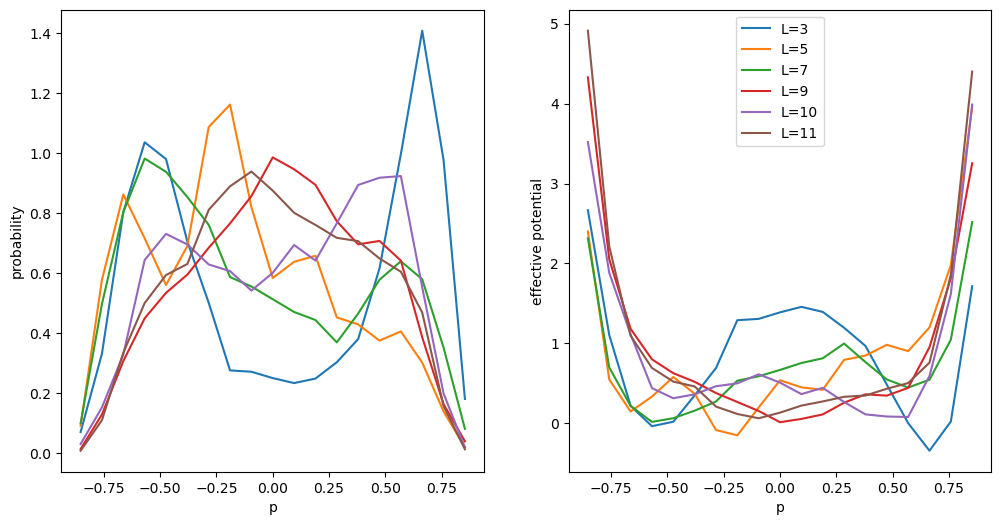

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
bins = np.linspace(-0.9, 0.9, 20)
mids = np.array([(x+y)/2 for (x, y) in zip(bins[:-1], bins[1:])])
Vs = [] 
for i in range(len(Ls)):
    counts, _ = np.histogram(np.sin(data[i][:, 1]), bins=bins, density=True)
    axs[0].plot(mids, counts, color=plt.cm.tab10(i))
    axs[1].plot(mids, -np.log(counts), label='L={}'.format(Ls[i]), color=plt.cm.tab10(i))
    Vs.append(-np.log(counts))
axs[0].set_xlabel('p')
axs[0].set_ylabel('probability')
axs[1].set_xlabel('p')
axs[1].set_ylabel('effective potential')
plt.legend()
plt.show() 

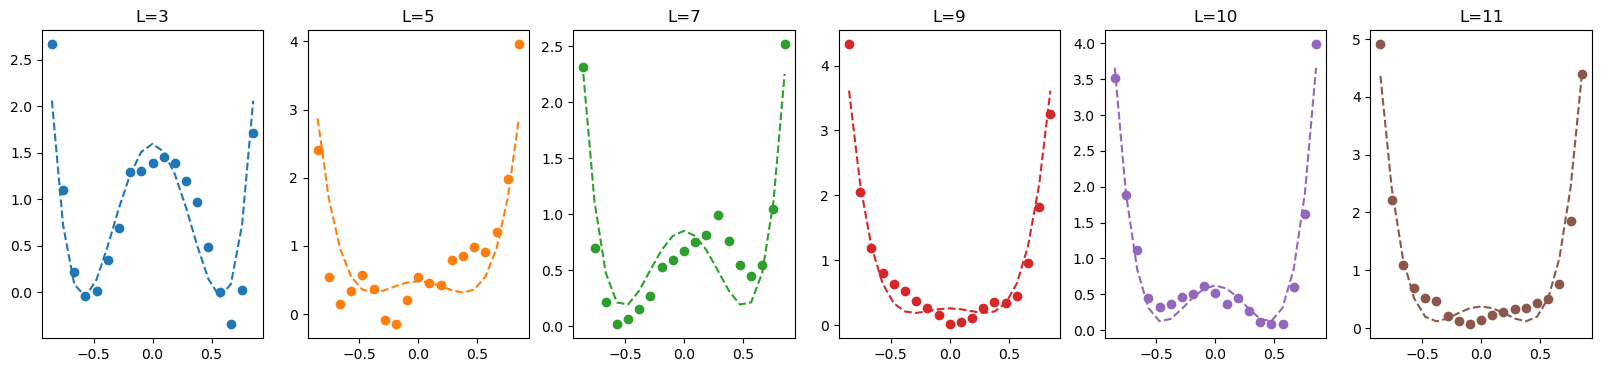

[[14.16918911 -9.66171835  1.59672897]
 [ 7.6259239  -2.26304938  0.48260079]
 [ 9.66786498 -5.10143541  0.85279989]
 [ 8.49093634 -1.56051114  0.26035104]
 [12.74555528 -5.08699781  0.62237372]
 [12.50038447 -3.59996273  0.37366463]]


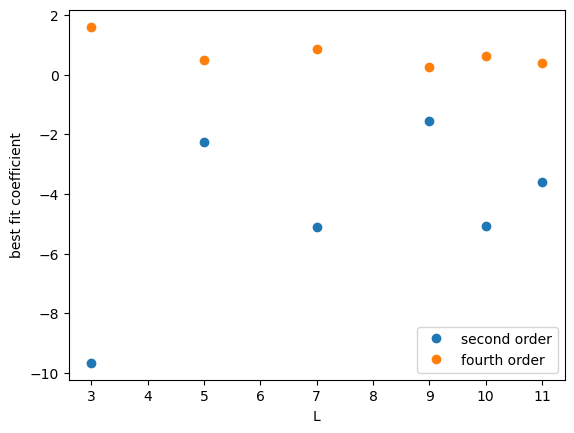

In [6]:
zs = [] 
fig, axes = plt.subplots(1, len(Ls), sharex=True, figsize=(20, 4))

for i in range(len(Ls)):
    z = np.polyfit(mids**2, Vs[i], deg=2)
    p = np.poly1d(z)
    axes[i].plot(mids, Vs[i], 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids, p(mids**2), '--', c=plt.cm.tab10(i))
    axes[i].set_title('L={}'.format(Ls[i]))
    zs.append(z)
plt.show() 

zs = np.array(zs)
print(zs)

plt.plot(Ls, zs[:, 1], 'o', label='second order')
plt.plot(Ls, zs[:, 2], 'o', label='fourth order')
plt.xlabel('L')
plt.ylabel('best fit coefficient')
plt.legend()
plt.show() 

In [51]:
Vs = np.array(Vs)
Rs = np.array(Ls)/2
mids = np.array(mids)
print(Vs.shape)

def get_V(params): 
    V = ( 0.5*np.outer((params[0] - params[1]/Rs), mids**2) +  
             0.25*params[2]*np.outer(1/Rs**3, mids**4) ) 
    Z = np.sum(np.exp(-V), axis=-1)*(mids[1]-mids[0])
    V += np.log(Z)[:, np.newaxis]
    return V 
    
def cost(params): 
    # quadratic cost function
    # params in order of gamma, a, b 
    V_fit = get_V(params)
    return np.sum((Vs-V_fit)**2)

guess = [1, 1, 1]
bounds = [[0, None]]*3
res = minimize(cost, guess, bounds=bounds, method='trust-constr')

(6, 19)


[ 17.94736324  48.62919586 158.53521329] 41.07550013327713


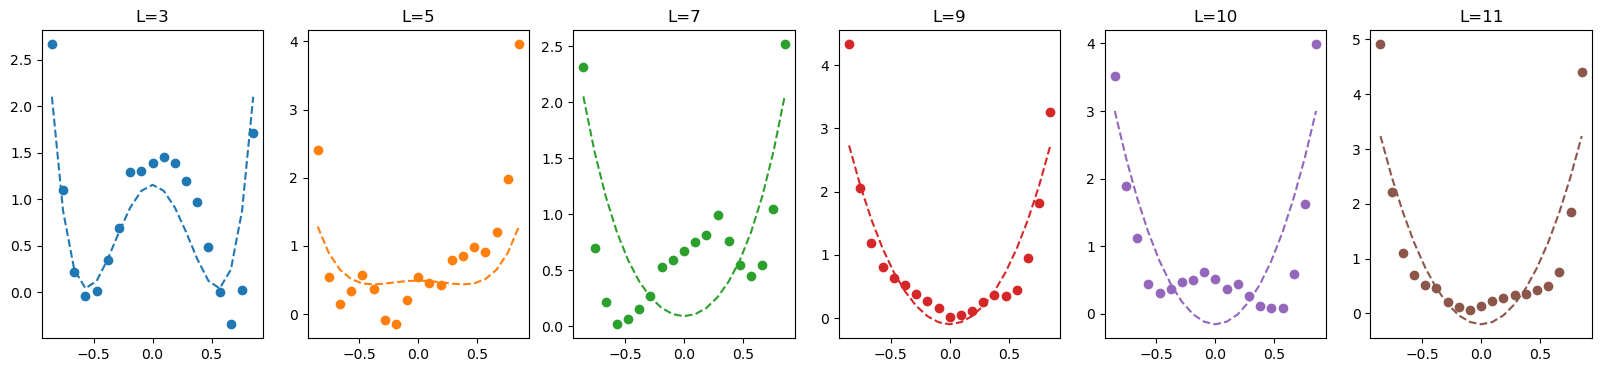

In [52]:
print(res.x, res.fun)
V_fit = get_V(res.x)

fig, axes = plt.subplots(1, len(Ls), sharex=True, figsize=(20, 4))
for (i, L) in enumerate(Ls): 
    axes[i].plot(mids, Vs[i], 'o', c=plt.cm.tab10(i))
    axes[i].plot(mids, V_fit[i], '--', c=plt.cm.tab10(i))
    axes[i].set_title('L={}'.format(L))
plt.show()

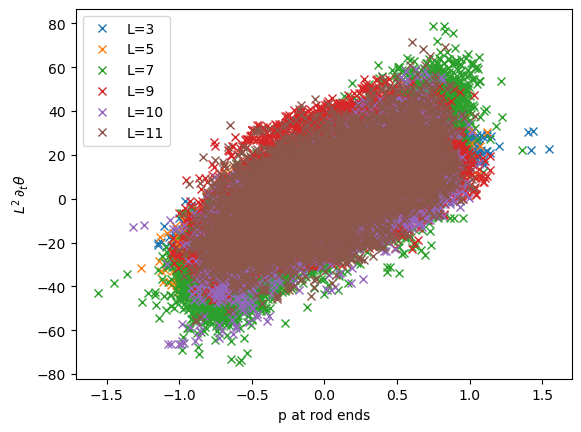

In [13]:
for (d, L) in zip(data, Ls): 
    plt.plot(d[:, 1], d[:, 0]*L*L, 'x', label='L={}'.format(L))
plt.legend()
plt.ylabel(r'$L^2 \, \partial_t \theta$')
plt.xlabel('p at rod ends')
plt.show()

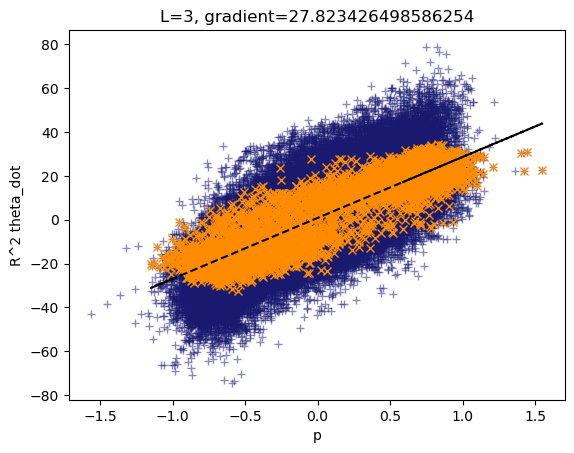

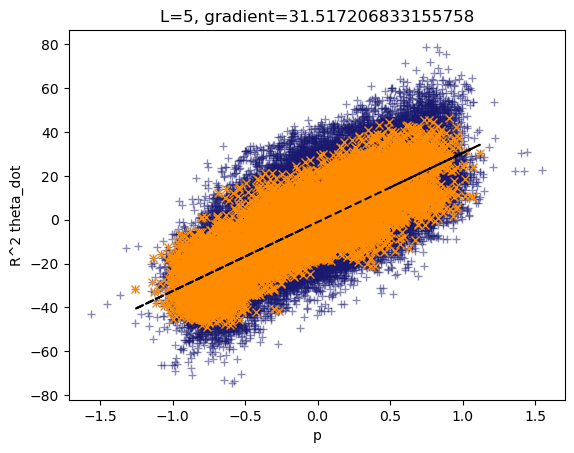

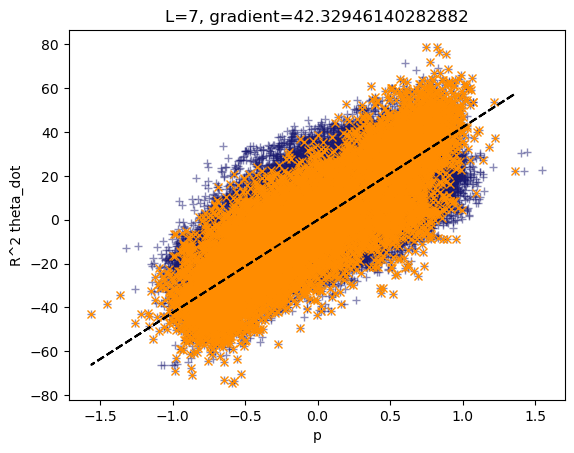

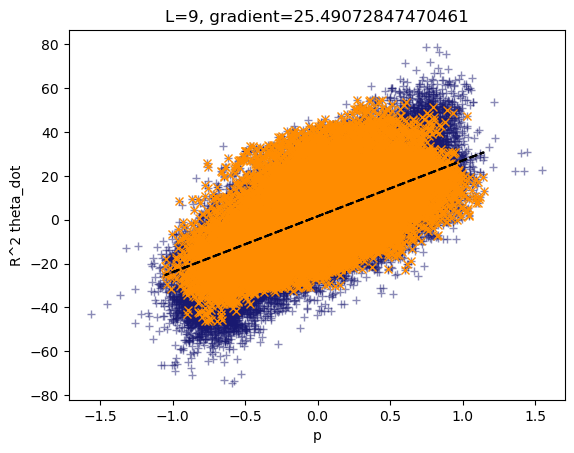

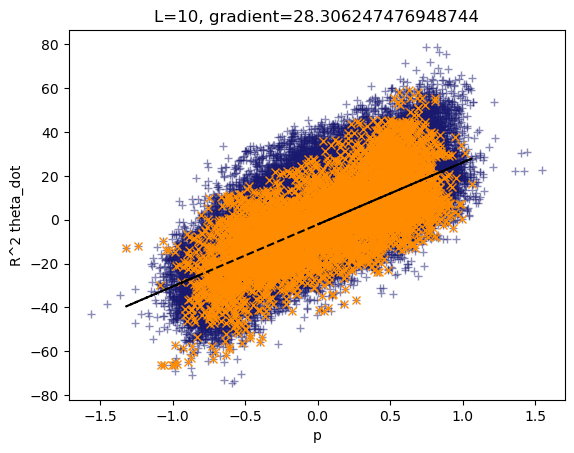

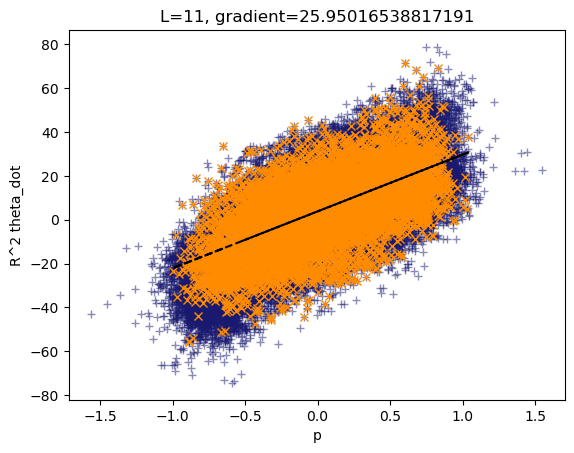

In [22]:
ms = [] 

for (d, L) in zip(data, Ls): 
    for (d2, L2) in zip(data, Ls): 
        plt.plot(d2[:, 1], d2[:, 0]*L2*L2, '+', alpha=0.5, color='midnightblue')
        
    y = d[:, 0]*L*L
    x = d[:, 1]
    plt.plot(x, y, 'x', color='darkorange')
    m, b = np.polyfit(x, y, 1)
    ms.append(m)

    plt.plot(x, m*x+b, '--k')
    plt.title('L={}, gradient={}'.format(L, m))
    plt.xlabel('p')
    plt.ylabel('R^2 theta_dot')
    plt.show() 

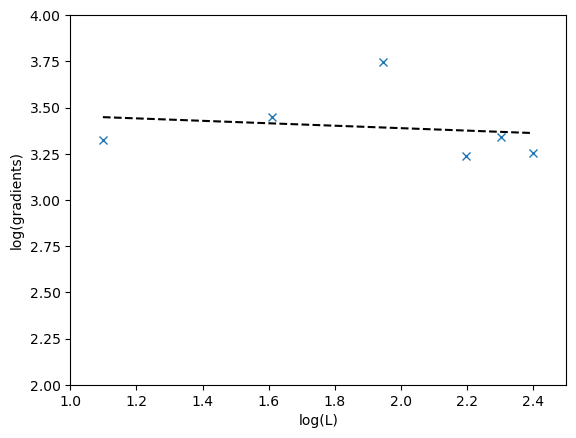

gradient =  -0.06619843731142651


In [23]:
m, b = np.polyfit(np.log(Ls), np.log(ms), 1)

plt.plot(np.log(Ls), np.log(ms), 'x')
plt.plot(np.log(Ls), m*np.log(Ls)+b, 'k--')
plt.xlim([1, 2.5])
plt.ylim([2, 4])
plt.xlabel('log(L)')
plt.ylabel('log(gradients)')
plt.show() 

print('gradient = ', m)